# USAD

## Environment

In [1]:
from utils import *
from usad import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

tf.enable_eager_execution()

## EDA - Data Pre-Processing

### Normal period

In [2]:
data_path = "C:\\Users\\PC\\OneDrive\\문서\\GitHub\\datasets\\"

#Read data
#data1_1 = pd.read_csv(data_path + "Bearing1_1.csv_wavelet_result.csv", usecols=['cD3', 'cD3.1'])
#data1_3 = pd.read_csv(data_path + "Bearing1_3.csv_wavelet_result.csv", usecols=['cD3', 'cD3.1'])

data1_1 = pd.read_csv(data_path + "Bearing1_1.csv")
data1_3 = pd.read_csv(data_path + "Bearing1_3.csv")

In [3]:
data1_1.head()

,Horiz,Verti
0,2.908484,1.458611
1,2.651959,1.457905
2,2.621243,1.364296
3,2.602309,1.617538
4,2.035000,1.228749


In [4]:
data1_1.shape

(2778, 2)

#### Normalization

In [5]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = data1_1.values
x_scaled = min_max_scaler.fit_transform(x)
scaled_data = pd.DataFrame(x_scaled)

In [6]:
scaled_data.head(2)

,0,1
0,0.031524,0.018592
1,0.026699,0.018578


### Windows

In [7]:
window_size=12

In [8]:
windows_normal=scaled_data.values[np.arange(window_size)[None, :] + np.arange(scaled_data.shape[0]-window_size)[:, None]]
windows_normal.shape

(2766, 12, 2)

## Training

In [9]:
BATCH_SIZE = 32
N_EPOCHS = 100
hidden_size = 10

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:400]
windows_normal_test = windows_normal[400:]

In [10]:
from tensorflow.keras.utils import Sequence
import math

class Dataloader(Sequence):
    def __init__(self, x_set, y_set, batch_size, shuffle=False):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    # batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
        # sampler의 역할(index를 batch_size만큼 sampling해줌)
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.array(batch_x), np.array(batch_y)

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [11]:
windows_normal_train_re = windows_normal_train.reshape(windows_normal_train.shape[0], w_size)
windows_normal_test_re = windows_normal_test.reshape(windows_normal_test.shape[0], w_size)
windows_normal_re = windows_normal.reshape(windows_normal.shape[0], w_size)

In [12]:
train_loader = Dataloader(windows_normal_train_re,windows_normal_train_re,BATCH_SIZE)
test_loader = Dataloader(windows_normal_test_re,windows_normal_test_re,BATCH_SIZE)
whole_loader = Dataloader(windows_normal_re,windows_normal_re,BATCH_SIZE)

* USAD tensorflow

In [13]:
class Encoder(tf.keras.Model) :
    def __init__(self, in_size, latent_size):
        super().__init__()
        self.model = tf.keras.Sequential([
            tf.keras.Input(shape = (in_size)),
            tf.keras.layers.Dense(int(in_size/2), activation = "relu"),
            tf.keras.layers.Dense(int(in_size/4), activation = "relu"),
            tf.keras.layers.Dense(latent_size, activation = "relu")
        ])
    
    def call(self, x) :
        z = self.model(x)
        return z
    
class Decoder(tf.keras.Model) :
    def __init__(self, latent_size, out_size):
        super().__init__()
        self.model = tf.keras.Sequential([
            tf.keras.Input(shape = (latent_size)),
            tf.keras.layers.Dense(int(out_size/4), activation = "relu"),
            tf.keras.layers.Dense(int(out_size/2), activation = "relu"),
            tf.keras.layers.Dense(out_size, activation = "sigmoid")
        ])
    
    def call(self, x) :
        w = self.model(x)
        return w
    
class UsadModel(tf.keras.Model):
    def __init__(self, w_size, z_size, alpha = .5, beta = .5):
        super().__init__()
        self.encoder = Encoder(w_size, z_size)
        self.decoder1 = Decoder(z_size, w_size)
        self.decoder2 = Decoder(z_size, w_size)
        
        self.latent_vector = self.encoder(self.encoder.model.inputs)
        self.ae_output1 = self.decoder1(self.latent_vector)
        self.ae_output2 = self.decoder2(self.latent_vector)

        self.ae_model1 = tf.keras.Model(inputs = self.encoder.model.inputs, outputs = self.ae_output1)
        self.ae_model2 = tf.keras.Model(inputs = self.encoder.model.inputs, outputs = self.ae_output2)
        
        self.optimizer = tf.keras.optimizers.Adam()
        
        self.alpha, self.beta = alpha, beta
        
    def evaluate(self, val_loader, n):
        outputs = [self.validation_step(batch, n) for batch in val_loader]
        return self.validation_epoch_end(outputs)
    
    def testing(self, test_loader):
        results=[]
        for batch, _ in test_loader:
            w1=self.ae_model1(batch)
            w2=self.ae_model2(w1)
            results.append(self.alpha*np.mean((batch-w1).numpy()**2, axis = 1)+self.beta*np.mean((batch-w2).numpy()**2, axis = 1))
        return results
        
    def call(self, x):
        z = self.encoder(x)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        return w1, w2, w3
    
    def loss_fn(self, batch, n) :
        loss1 = 1/n*tf.reduce_mean(tf.square(batch-self.w1)) + (1-1/n)*tf.reduce_mean(tf.square(batch-self.w3))
        loss2 = 1/n*tf.reduce_mean(tf.square(batch-self.w2)) + (1-1/n)*tf.reduce_mean(tf.square(batch-self.w3))
        
        return loss1, loss2
    
    def training(self, train_loader, val_loader, num_epochs):
        for n in range(num_epochs): 
            n += 1
            
            loss1_list, loss2_list = [], []
            self.history = []
            
            # Iterate over the batches of a dataset.
            for x_batch_train, y_batch_train in train_loader:
                with tf.GradientTape() as ae1_tape, tf.GradientTape() as ae2_tape:
                    self.z = self.encoder(x_batch_train)
                    self.w1 = self.decoder1(self.z)
                    self.w2 = self.decoder2(self.z)
                    self.w3 = self.decoder2(self.encoder(self.w1))

                    # Loss value for this minibatch
                    loss1, loss2 = self.loss_fn(x_batch_train, n)
                    
                    # Add extra losses created during this forward pass:
                    #loss_value += sum(model.losses)

                grads_ae1 = ae1_tape.gradient(loss1, self.ae_model1.trainable_weights)
                self.optimizer.apply_gradients(zip(grads_ae1, self.ae_model1.trainable_weights))
                grads_ae2 = ae2_tape.gradient(loss2, self.ae_model2.trainable_weights)
                self.optimizer.apply_gradients(zip(grads_ae2, self.ae_model2.trainable_weights))
                loss1_list.append(loss1)
                loss2_list.append(loss2)
                
            #print("Epoch [{}], train_loss1: {:.4f}, train_loss2: {:.4f}".format(n, np.mean(loss1_list), np.mean(loss2_list)))
            result = self.evaluate(val_loader, n)
            self.epoch_end(n, result)
            self.history.append(result)
            
    def validation_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        loss1 = 1/n*tf.reduce_mean(tf.square(batch-w1)) + (1-1/n)*tf.reduce_mean(tf.square(batch-w3))
        loss2 = 1/n*tf.reduce_mean(tf.square(batch-w2)) + (1-1/n)*tf.reduce_mean(tf.square(batch-w3))
        
        return {'val_loss1': loss1, 'val_loss2': loss2}
    
    def validation_epoch_end(self, outputs):
        batch_losses1 = [x['val_loss1'] for x in outputs]
        epoch_loss1 = tf.reduce_mean(batch_losses1)
        batch_losses2 = [x['val_loss2'] for x in outputs]
        epoch_loss2 = tf.reduce_mean(batch_losses2)
        return {'val_loss1': epoch_loss1.numpy(), 'val_loss2': epoch_loss2.numpy()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2']))

In [14]:
model_usad = UsadModel(w_size, z_size)
model_usad.training(train_loader, test_loader, N_EPOCHS)

Epoch [1], val_loss1: 0.2214, val_loss2: 0.2171
Epoch [2], val_loss1: 0.1896, val_loss2: 0.1803
Epoch [3], val_loss1: 0.1391, val_loss2: 0.1237
Epoch [4], val_loss1: 0.0843, val_loss2: 0.0657
Epoch [5], val_loss1: 0.0433, val_loss2: 0.0255
Epoch [6], val_loss1: 0.0259, val_loss2: 0.0121
Epoch [7], val_loss1: 0.0163, val_loss2: 0.0081
Epoch [8], val_loss1: 0.0098, val_loss2: 0.0061
Epoch [9], val_loss1: 0.0060, val_loss2: 0.0049
Epoch [10], val_loss1: 0.0047, val_loss2: 0.0045
Epoch [11], val_loss1: 0.0042, val_loss2: 0.0042
Epoch [12], val_loss1: 0.0041, val_loss2: 0.0040
Epoch [13], val_loss1: 0.0040, val_loss2: 0.0040
Epoch [14], val_loss1: 0.0040, val_loss2: 0.0040
Epoch [15], val_loss1: 0.0040, val_loss2: 0.0040
Epoch [16], val_loss1: 0.0040, val_loss2: 0.0040
Epoch [17], val_loss1: 0.0041, val_loss2: 0.0040
Epoch [18], val_loss1: 0.0041, val_loss2: 0.0040
Epoch [19], val_loss1: 0.0041, val_loss2: 0.0041
Epoch [20], val_loss1: 0.0041, val_loss2: 0.0041
Epoch [21], val_loss1: 0.0042

In [15]:
a = model_usad.testing(whole_loader)
a = np.concatenate([np.stack(a[:-1]).flatten(), a[-1].flatten()])
b = model_usad.testing(train_loader)
b = np.concatenate([np.stack(b[:-1]).flatten(), b[-1].flatten()])

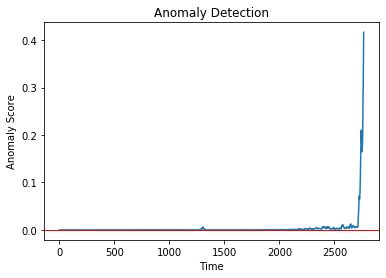

In [16]:
from matplotlib import pyplot as plt

plt.plot([x for x in range(a.shape[0])], a)
plt.axhline(y=b.mean() + 5 * b.std(), color='r', linewidth=1)
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.show()

In [17]:
b.mean() + 5 * b.std()

0.00023435933144355658

In [18]:
start_idx = np.max(np.where(a < b.mean() + 5 * b.std())[0]); start_idx

1895

In [20]:
a_ = a[:1895]
np.where(a_ > b.mean() + 5 * b.std())[0].shape

(705,)

## Anomaly gap maximize net

* 제안 아이디어 검증

In [21]:
class UsadModel_AGM(tf.keras.Model):
    def __init__(self, w_size, z_size, alpha = .5, beta = .5):
        super().__init__()
        self.encoder = Encoder(w_size, z_size)
        self.decoder1 = Decoder(z_size, w_size)
        self.decoder2 = Decoder(z_size, w_size)
        
        self.latent_vector = self.encoder(self.encoder.model.inputs)
        self.ae_output1 = self.decoder1(self.latent_vector)
        self.ae_output2 = self.decoder2(self.latent_vector)

        self.ae_model1 = tf.keras.Model(inputs = self.encoder.model.inputs, outputs = self.ae_output1)
        self.ae_model2 = tf.keras.Model(inputs = self.encoder.model.inputs, outputs = self.ae_output2)
        
        self.optimizer = tf.keras.optimizers.Adam()
        
        self.alpha, self.beta = alpha, beta
        
    def evaluate(self, val_loader, n):
        outputs = [self.validation_step(batch, n) for batch in val_loader]
        return self.validation_epoch_end(outputs)

    def testing(self, test_loader):
        results=[]
        for batch, _ in test_loader:
            w1=self.ae_model1(batch)
            w2=self.ae_model2(w1)
            results.append(self.alpha*np.mean((batch-w1).numpy()**2, axis = 1)+self.beta*np.mean((batch-w2).numpy()**2, axis = 1))
        return results
        
    def call(self, x):
        z = self.encoder(x)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        return w1, w2, w3
    
    def loss_fn(self, batch, n) :
        loss1 = 1/n*tf.reduce_mean(tf.square(batch-self.w1)) + (1-1/n)*tf.reduce_mean(tf.square(batch-self.w3))
        loss2 = 1/n*tf.reduce_mean(tf.square(batch-self.w2)) + (1-1/n)*tf.reduce_mean(tf.square(batch-self.w3))
        
        return loss1, loss2
    
    def training(self, train_loader, val_loader, num_epochs):
        self.history = []
        
        for n in range(num_epochs): 
            n += 1
            
            loss1_list, loss2_list, loss3_list = [], [], []
            
            # Iterate over the batches of a dataset.
            for x_batch_train, y_batch_train in train_loader:
                with tf.GradientTape() as ae1_tape, tf.GradientTape() as ae2_tape, tf.GradientTape() as pg_tape:
                    self.z = self.encoder(x_batch_train)
                    self.w1 = self.decoder1(self.z)
                    self.w2 = self.decoder2(self.z)
                    self.w3 = self.decoder2(self.encoder(self.w1))
                    
                    real_recon1 = x_batch_train-self.w1
                    real_recon2 = x_batch_train-self.w2
                    fake_recon = x_batch_train-self.w3

                    # Loss value for this minibatch
                    loss1, loss2 = self.loss_fn(x_batch_train, n)
                    
                    pg_advantage = tf.stop_gradient(tf.reduce_mean(tf.square(fake_recon))-tf.reduce_mean(tf.square(real_recon2)))
                    loss3 = -tf.reduce_mean(tf.math.log(self.w3+1e-6) * pg_advantage)
        
                    
                    # Add extra losses created during this forward pass:
                    #loss_value += sum(model.losses)

                grads_ae1 = ae1_tape.gradient(loss1, self.ae_model1.trainable_weights)
                self.optimizer.apply_gradients(zip(grads_ae1, self.ae_model1.trainable_weights))
                grads_ae2 = ae2_tape.gradient(loss2, self.ae_model2.trainable_weights)
                self.optimizer.apply_gradients(zip(grads_ae2, self.ae_model2.trainable_weights))
                grads_ae3 = pg_tape.gradient(loss3, self.ae_model2.trainable_weights)
                self.optimizer.apply_gradients(zip(grads_ae3, self.ae_model2.trainable_weights))
                
                loss1_list.append(loss1)
                loss2_list.append(loss2)
                loss3_list.append(loss3)
                
            result = self.evaluate(val_loader, n)
            self.epoch_end(n, result)
            self.history.append(result)
                
            #print("Epoch [{}], train_loss1: {:.4f}, train_loss2: {:.4f}, train_loss3: {:.4f}".format(n, np.mean(loss1_list), np.mean(loss2_list), np.mean(loss3_list)))
            
    def validation_step(self, batch, n):
        z = self.encoder(batch)
        w1 = self.decoder1(z)
        w2 = self.decoder2(z)
        w3 = self.decoder2(self.encoder(w1))
        
        real_recon1 = batch-w1
        real_recon2 = batch-w2
        fake_recon = batch-w3
                
        loss1 = 1/n*tf.reduce_mean(tf.square(batch-w1)) + (1-1/n)*tf.reduce_mean(tf.square(batch-w3))
        loss2 = 1/n*tf.reduce_mean(tf.square(batch-w2)) + (1-1/n)*tf.reduce_mean(tf.square(batch-w3))
        
        pg_advantage = tf.reduce_mean(tf.square(fake_recon))-tf.reduce_mean(tf.square(real_recon2))
        loss3 = -tf.reduce_mean(tf.math.log(w3+1e-6) * pg_advantage)
        
        return {'val_loss1': loss1, 'val_loss2': loss2, 'val_loss3': loss3}
    
    def validation_epoch_end(self, outputs):
        batch_losses1 = [x['val_loss1'] for x in outputs]
        epoch_loss1 = tf.reduce_mean(batch_losses1)
        batch_losses2 = [x['val_loss2'] for x in outputs]
        epoch_loss2 = tf.reduce_mean(batch_losses2)
        batch_losses3 = [x['val_loss3'] for x in outputs]
        epoch_loss3 = tf.reduce_mean(batch_losses3)
        return {'val_loss1': epoch_loss1.numpy(), 'val_loss2': epoch_loss2.numpy(), 'val_loss3': epoch_loss3.numpy()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss1: {:.4f}, val_loss2: {:.4f}, val_loss2: {:.4f}".format(epoch, result['val_loss1'], result['val_loss2'], result['val_loss3']))

In [22]:
usad_agm = UsadModel_AGM(w_size,z_size)

In [23]:
usad_agm.training(train_loader, test_loader, N_EPOCHS)

Epoch [1], val_loss1: 0.2208, val_loss2: 0.2198, val_loss2: -0.0002
Epoch [2], val_loss1: 0.2010, val_loss2: 0.1972, val_loss2: -0.0125
Epoch [3], val_loss1: 0.1459, val_loss2: 0.1322, val_loss2: -0.0470
Epoch [4], val_loss1: 0.0804, val_loss2: 0.0627, val_loss2: -0.0721
Epoch [5], val_loss1: 0.0240, val_loss2: 0.0087, val_loss2: -0.1207
Epoch [6], val_loss1: 0.0145, val_loss2: 0.0055, val_loss2: -0.0313
Epoch [7], val_loss1: 0.0095, val_loss2: 0.0053, val_loss2: -0.0164
Epoch [8], val_loss1: 0.0069, val_loss2: 0.0051, val_loss2: -0.0116
Epoch [9], val_loss1: 0.0057, val_loss2: 0.0049, val_loss2: -0.0086
Epoch [10], val_loss1: 0.0053, val_loss2: 0.0049, val_loss2: -0.0061
Epoch [11], val_loss1: 0.0051, val_loss2: 0.0050, val_loss2: -0.0043
Epoch [12], val_loss1: 0.0051, val_loss2: 0.0050, val_loss2: -0.0032
Epoch [13], val_loss1: 0.0050, val_loss2: 0.0050, val_loss2: -0.0025
Epoch [14], val_loss1: 0.0050, val_loss2: 0.0050, val_loss2: -0.0022
Epoch [15], val_loss1: 0.0050, val_loss2: 0

## Testing

In [27]:
a = model_usad.testing(whole_loader)
a = np.concatenate([np.stack(a[:-1]).flatten(), a[-1].flatten()])
b = model_usad.testing(train_loader)
b = np.concatenate([np.stack(b[:-1]).flatten(), b[-1].flatten()])

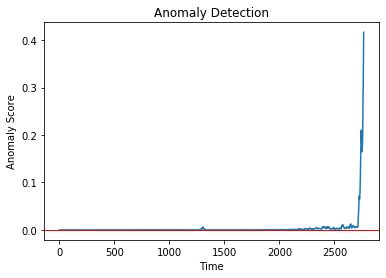

In [28]:
from matplotlib import pyplot as plt

plt.plot([x for x in range(a.shape[0])], a)
plt.axhline(y=b.mean() + 5 * b.std(), color='r', linewidth=1)
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.show()

In [29]:
b.mean() + 5 * b.std()

0.00023435933144355658

In [30]:
start_idx = np.max(np.where(a < b.mean() + 5 * b.std())[0]); start_idx

1895

In [31]:
a_ = a[:start_idx]
np.where(a_ > b.mean() + 5 * b.std())[0].shape

(583,)

## bearing 1_3

#### Normalization

In [32]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = data1_3.values
x_scaled = min_max_scaler.fit_transform(x)
scaled_data = pd.DataFrame(x_scaled)

In [33]:
scaled_data.head(2)

,0,1
0,0.009587,0.014028
1,0.012601,0.009091


### Windows

In [34]:
window_size=12

In [35]:
windows_normal=scaled_data.values[np.arange(window_size)[None, :] + np.arange(scaled_data.shape[0]-window_size)[:, None]]
windows_normal.shape

(2341, 12, 2)

## Training

In [36]:
BATCH_SIZE = 32
N_EPOCHS = 100
hidden_size = 10

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:400]
windows_normal_test = windows_normal[400:]

In [37]:
windows_normal_train_re = windows_normal_train.reshape(windows_normal_train.shape[0], w_size)
windows_normal_test_re = windows_normal_test.reshape(windows_normal_test.shape[0], w_size)
windows_normal_re = windows_normal.reshape(windows_normal.shape[0], w_size)

In [38]:
train_loader = Dataloader(windows_normal_train_re,windows_normal_train_re,BATCH_SIZE)
test_loader = Dataloader(windows_normal_test_re,windows_normal_test_re,BATCH_SIZE)
whole_loader = Dataloader(windows_normal_re,windows_normal_re,BATCH_SIZE)

* usad

In [39]:
model_usad = UsadModel(w_size, z_size)
model_usad.training(train_loader, test_loader, N_EPOCHS)

Epoch [1], val_loss1: 0.2044, val_loss2: 0.2019
Epoch [2], val_loss1: 0.1738, val_loss2: 0.1653
Epoch [3], val_loss1: 0.1337, val_loss2: 0.1200
Epoch [4], val_loss1: 0.0901, val_loss2: 0.0754
Epoch [5], val_loss1: 0.0482, val_loss2: 0.0356
Epoch [6], val_loss1: 0.0233, val_loss2: 0.0155
Epoch [7], val_loss1: 0.0149, val_loss2: 0.0115
Epoch [8], val_loss1: 0.0112, val_loss2: 0.0100
Epoch [9], val_loss1: 0.0101, val_loss2: 0.0097
Epoch [10], val_loss1: 0.0098, val_loss2: 0.0097
Epoch [11], val_loss1: 0.0098, val_loss2: 0.0098
Epoch [12], val_loss1: 0.0099, val_loss2: 0.0098
Epoch [13], val_loss1: 0.0100, val_loss2: 0.0099
Epoch [14], val_loss1: 0.0101, val_loss2: 0.0100
Epoch [15], val_loss1: 0.0102, val_loss2: 0.0101
Epoch [16], val_loss1: 0.0102, val_loss2: 0.0102
Epoch [17], val_loss1: 0.0103, val_loss2: 0.0103
Epoch [18], val_loss1: 0.0104, val_loss2: 0.0103
Epoch [19], val_loss1: 0.0104, val_loss2: 0.0104
Epoch [20], val_loss1: 0.0105, val_loss2: 0.0105
Epoch [21], val_loss1: 0.0105

In [40]:
a = model_usad.testing(whole_loader)
a = np.concatenate([np.stack(a[:-1]).flatten(), a[-1].flatten()])
b = model_usad.testing(train_loader)
b = np.concatenate([np.stack(b[:-1]).flatten(), b[-1].flatten()])

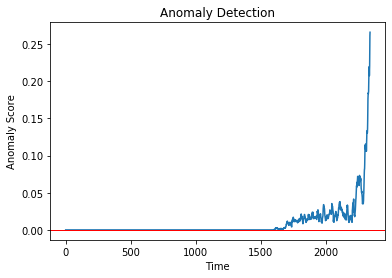

In [41]:
from matplotlib import pyplot as plt

plt.plot([x for x in range(a.shape[0])], a)
plt.axhline(y=b.mean() + 5 * b.std(), color='r', linewidth=1)
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.show()

In [42]:
b.mean() + 5 * b.std()

0.00010550405386311468

In [43]:
start_idx = np.max(np.where(a < b.mean() + 5 * b.std())[0]); start_idx

1600

In [44]:
a_ = a[:start_idx]
np.where(a_ > b.mean() + 5 * b.std())[0].shape

(157,)

* usad agm

In [45]:
usad_agm = UsadModel_AGM(w_size,z_size)

In [46]:
usad_agm.training(train_loader, test_loader, N_EPOCHS)

Epoch [1], val_loss1: 0.2024, val_loss2: 0.2027, val_loss2: 0.0004
Epoch [2], val_loss1: 0.1795, val_loss2: 0.1768, val_loss2: -0.0133
Epoch [3], val_loss1: 0.1217, val_loss2: 0.1117, val_loss2: -0.0625
Epoch [4], val_loss1: 0.0557, val_loss2: 0.0401, val_loss2: -0.1719
Epoch [5], val_loss1: 0.0269, val_loss2: 0.0140, val_loss2: -0.1356
Epoch [6], val_loss1: 0.0190, val_loss2: 0.0124, val_loss2: -0.0616
Epoch [7], val_loss1: 0.0141, val_loss2: 0.0115, val_loss2: -0.0408
Epoch [8], val_loss1: 0.0115, val_loss2: 0.0105, val_loss2: -0.0331
Epoch [9], val_loss1: 0.0107, val_loss2: 0.0103, val_loss2: -0.0285
Epoch [10], val_loss1: 0.0104, val_loss2: 0.0101, val_loss2: -0.0266
Epoch [11], val_loss1: 0.0102, val_loss2: 0.0100, val_loss2: -0.0268
Epoch [12], val_loss1: 0.0100, val_loss2: 0.0098, val_loss2: -0.0295
Epoch [13], val_loss1: 0.0097, val_loss2: 0.0095, val_loss2: -0.0379
Epoch [14], val_loss1: 0.0094, val_loss2: 0.0089, val_loss2: -0.0589
Epoch [15], val_loss1: 0.0088, val_loss2: 0.

In [47]:
a = model_usad.testing(whole_loader)
a = np.concatenate([np.stack(a[:-1]).flatten(), a[-1].flatten()])
b = model_usad.testing(train_loader)
b = np.concatenate([np.stack(b[:-1]).flatten(), b[-1].flatten()])

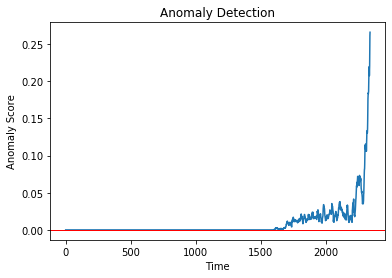

In [48]:
from matplotlib import pyplot as plt

plt.plot([x for x in range(a.shape[0])], a)
plt.axhline(y=b.mean() + 5 * b.std(), color='r', linewidth=1)
plt.title('Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.show()

In [49]:
b.mean() + 5 * b.std()

0.00010550405386311468

In [50]:
start_idx = np.max(np.where(a < b.mean() + 5 * b.std())[0]); start_idx

1600

In [51]:
a_ = a[:start_idx]
np.where(a_ > b.mean() + 5 * b.std())[0].shape

(157,)